In [1]:
import time
start_time=time.time()

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy import interpolate

Data load

In [3]:
pickle_in = open('604IHA.pkl',"rb")
data = pickle.load(pickle_in)
data

,X,Y,Center,Peak,Width,RV,Sig
41,144.83,19.6,6556.792,73.97,0.780,-248.499450,NaN
42,143.49,19.6,6556.771,94.17,0.926,-249.458742,NaN
43,142.15,19.6,6556.704,101.40,0.970,-252.519340,NaN
44,140.81,19.6,6556.538,118.20,1.154,-260.102315,8.930295
51,131.42,19.6,6556.464,1769.00,0.997,-263.482678,NaN
...,...,...,...,...,...,...,...
1434,87.17,0.0,6557.031,686.50,1.049,-237.581793,NaN
1435,85.82,0.0,6556.998,515.70,1.052,-239.089252,NaN
1436,84.48,0.0,6556.978,410.70,1.088,-240.002864,4.903321
1437,83.14,0.0,6557.046,424.80,0.988,-236.896585,NaN


Bidimensional Data Display

(61.75399999999999, 148.786, -0.9800000000000001, 20.580000000000002)

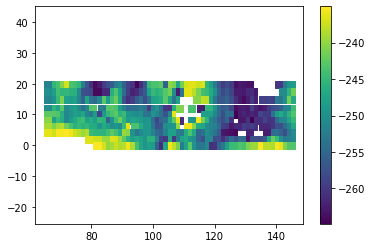

In [4]:
plt.scatter(data.X,data.Y,c=data.RV, s=50,marker='s')
plt.colorbar()
plt.axis('equal')

Second order Structure Function:
$$S_{2}(l)=\langle {\vert \overrightarrow{v}(\overrightarrow{x}+\overrightarrow{l})-\overrightarrow{v}(\overrightarrow{x}) \vert}^{2} \rangle \propto (\epsilon l)^{2 / 3} $$
applied to the bidimensional map (Turbulence case)

Data Rearrange

In [5]:
df1=data[['X', 'Y', 'RV']].copy()
df1n=df1.to_numpy()

In [6]:
xl=[row[0] for row in df1n]
yl=[row[1] for row in df1n]
fl=[row[2] for row in df1n]

x1=[xl]
y1=[yl]
f1=[fl]

x=list(map(list, zip(*x1)))
y=list(map(list, zip(*y1)))
f=list(map(list, zip(*f1)))

Structure Function code

In [7]:
sig2=2*(data.RV.var())
fm=np.nanmean(f)
fv=np.nanvar(f,ddof=1)
fs=np.nanstd(f,ddof=1)
l=len(f)
S=[[fm],[fv],[fs],[l]]

In [8]:
a=[[0]*(l) for i in range(l)]
b=[[0]*(l) for i in range(l)]
c=[[0]*(2) for i in range(l*l)]

In [9]:
#Second Order Structure Function Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            a[i][j]=(((f[j][0])-(f[i][0]))**2)

#Normalized Second Order Structure Function Matrix [LxL]
#for i in range(l):
#    for j in range(l):
#        if i > j:
#            a[i][j]=(((f[j][0]-fm)-(f[i][0]-fm))**2)/(fv)       

In [10]:
#Coord Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            b[i][j]=((x[i][0]-x[j][0])**2+(y[i][0]-y[j][0])**2)**0.5 

In [11]:
#LxL to Lx2
#Main Matrix  [(L*L)x2]
for j in range (l):
    for i in range (l):
        c[i+j*(l)][1]=a[i][j]

for j in range (l):
    for i in range (l):
        c[i+j*(l)][0]=b[i][j]

In [12]:
#pd.DataFrame(a)

In [13]:
#pd.DataFrame(b)

In [14]:
#Filter: Greater than "0"
d=np.asarray(c)
ind=np.squeeze(d[:,1])>0.0
e=d[ind]

df=pd.DataFrame(e)
df.columns=['lag','qvd']#squared velocities difference
df.describe()

,lag,qvd
count,137306.000000,137306.000000
mean,28.469267,115.869462
std,17.516579,144.239743
min,1.340000,0.002087
25%,14.462783,12.695572
50%,24.770242,58.895435
75%,40.341702,165.943898
max,81.511560,889.793917


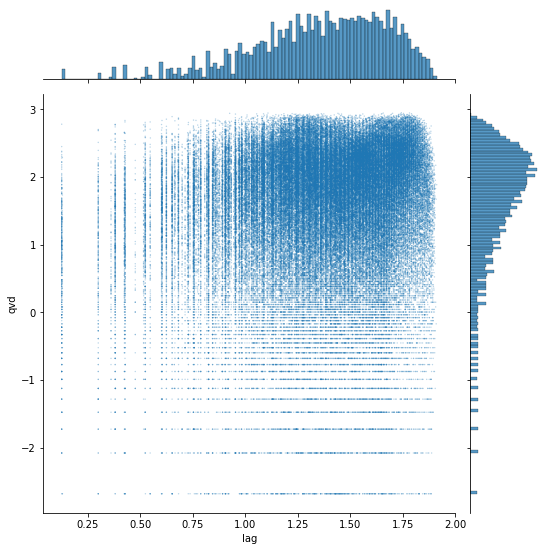

In [15]:
ax=sns.jointplot(x=np.log10(df.lag), y=np.log10(df.qvd), alpha=0.3, s=2, edgecolor='none')
ax.fig.set_size_inches(8,8)

Structure Function Data Groups

In [16]:
m=1.341#separation between lags mib valu=min lag

In [17]:
n=df.lag.max()//m#Number of points
n

60.0

In [18]:
#Grouping points
dfx = dict()

for i in range(int(n)):
    p = 0 + i*m
    q = m + i*m
    dfx[i] = df[df['lag'].between(p,q)]
    
dfx

{0:          lag        qvd
 0       1.34   0.920241
 523     1.34   9.367262
 1046    1.34  57.501510
 2608    1.34   0.169024
 3642    1.34  16.159518
 ...      ...        ...
 137285  1.34   0.408996
 137291  1.34   1.521215
 137300  1.34   0.834686
 137303  1.34   9.648969
 137305  1.34   2.856712
 
 [438 rows x 2 columns],
 1:              lag         qvd
 1       2.680000   16.159518
 52      2.300000   48.211456
 53      2.661879    8.547183
 524     2.680000  113.285653
 574     2.661879   62.453283
 ...          ...         ...
 137279  2.680000    9.934849
 137286  2.680000    0.352655
 137296  1.350000    2.272432
 137301  2.680000    4.807791
 137304  2.680000   23.006029
 
 [1569 rows x 2 columns],
 2:              lag         qvd
 2       4.020000  134.626484
 54      3.531629    3.858335
 1095    3.531629  120.194765
 1617    3.531629  211.016935
 2089    4.020000    0.469511
 ...          ...         ...
 137264  4.020000   32.085325
 137280  4.020000    3.680965
 13729

In [19]:
#Log Grouping 
d_log_s = 2.5
log_s_min = np.min(df["lag"])
#log_s_min = 1.0
ils = ((df["lag"] - log_s_min) / d_log_s).astype(int).rename("ils")
ils[ils < 0] = 0

In [20]:
table = df[['lag', 'qvd']].groupby(ils).describe()
table

lag                                                                   \
      count       mean       std        min        25%        50%        75%   
ils                                                                            
0    3000.0   2.533493  0.688820   1.340000   2.000000   2.661879   3.289757   
1    5545.0   5.080346  0.724264   4.000000   4.490033   5.176447   5.720979   
2    6672.0   7.580799  0.667420   6.415637   7.000000   7.776400   8.111449   
3    8174.0  10.061120  0.718589   8.953234   9.396400  10.040045  10.730000   
4    9047.0  12.603500  0.744863  11.342028  12.070000  12.511071  13.384054   
5    9177.0  15.168657  0.733831  13.861544  14.629563  15.237287  15.803876   
6    8366.0  17.605115  0.692580  16.367287  17.023587  17.581095  18.055495   
7    8239.0  19.995673  0.720496  18.876252  19.335160  20.094897  20.513761   
8    7375.0  22.475165  0.700173  21.341155  21.829604  22.468075  23.012570   
9    6986.0  25.007871  0.712059  23.840807  24.253280  25.081916  25.558372   
10   6613.0  27.611603  0.738768  26.347533  26.894468  27.561379  28.253771   
11   5782.0  30.192200  0.697370  28.873533  29.577696  30.103986  30.904783   
12   5407.0  32.699608  0.710931  31.418237  32.190000  32.517012  33.496901   
13   4999.0  35.183014  0.723768  33.844067  34.706662  35.098674  35.770883   
14   4334.0  37.498131  0.660819  36.420324  36.877051  37.598232  37.959411   
15   4741.0  39.902101  0.731933  38.849088  39.161104  40.000961  40.428368   
16   4356.0  42.490996  0.717007  41.343591  41.762003  42.533104  43.096033   
17   4104.0  45.102251  0.724288  43.843678  44.400731  45.026158  45.698578   
18   3651.0  47.669898  0.691966  46.379177  46.996315  47.584872  48.321407   
19   3423.0  50.193476  0.730299  48.860873  49.650298  50.078422  50.960000   
20   2978.0  52.702105  0.727970  51.361874  52.300000  52.592030  53.444270   
21   2435.0  55.023898  0.687021  53.872531  54.492018  55.028087  55.462513   
22   2417.0  57.369714  0.719420  56.355500  56.638701  57.637578  57.878829   
23   2132.0  59.916201  0.707808  58.895463  59.174028  59.851317  60.482415   
24   1843.0  62.530391  0.715712  61.344295  61.819545  62.432492  63.156796   
25   1491.0  65.135165  0.693761  63.972810  64.484181  64.996130  65.778447   
26   1190.0  67.679775  0.705596  66.354955  67.089437  67.525569  68.419238   
27   1013.0  70.218786  0.740270  68.840849  69.758676  70.080474  71.080000   
28    746.0  72.631702  0.714056  71.388815  72.259023  72.530383  73.107157   
29    573.0  74.891854  0.697632  73.858395  74.182629  75.100000  75.339299   
30    390.0  77.281951  0.695240  76.440000  76.588353  77.113043  77.882786   
31    106.0  79.460085  0.475881  78.858915  79.145274  79.297316  79.680728   
32      1.0  81.511560       NaN  81.511560  81.511560  81.511560  81.511560   

                   qvd                                                \
           max   count        mean         std        min        25%   
ils                                                                    
0     3.539223  3000.0   37.887155   72.659209   0.002087   2.272432   
1     6.151171  5545.0   60.786781   90.909817   0.002087   5.216787   
2     8.822522  6672.0   77.413461  105.815838   0.002087   7.512173   
3    11.324138  8174.0   91.826754  119.788217   0.002087  10.224902   
4    13.748604  9047.0  105.287672  130.997902   0.002087  12.052864   
5    16.335777  9177.0  117.655212  144.902383   0.002087  13.690935   
6    18.835713  8366.0  130.036281  160.056368   0.002087  14.375377   
7    21.335501  8239.0  129.049620  162.260544   0.002087  13.690935   
8    23.748434  7375.0  120.553941  152.324806   0.002087  13.690935   
9    26.245762  6986.0  113.647583  141.090559   0.002087  13.023186   
10   28.802778  6613.0  109.254218  138.195159   0.002087  12.695572   
11   31.301957  5782.0  109.951486  136.378927   0.002087  14.031069   
12   33.834160  5407.0  112.191220  131.283499 

Main Matrix Statistical Properties Groups

In [21]:
lgp=dict()
dl=dict()
dery=dict()
dfm=dict()
dfv=dict()
dfs=dict()
derx=dict()
dlm=dict()
dlv=dict()
dls=dict()

In [22]:
n=len(dfx)

for i in range(n):
    lgp[i]=(dfx[i]["lag"].max())
    dl[i]=len(dfx[i])#Numer of points each group
    #errorY
    dfm[i]=dfx[i]["qvd"].mean()
    dfv[i]=dfx[i]["qvd"].var()
    dfs[i]=dfx[i]["qvd"].std()
    if dl[i]>0:
        dery[i]=dfs[i]/np.sqrt(dl[i])
    #errorX
    dlm[i]=dfx[i]["lag"].mean()
    dlv[i]=dfx[i]["lag"].var()
    dls[i]=dfx[i]["lag"].std()
    if dl[i]>0:
        derx[i]=dls[i]/np.sqrt(dl[i])  


In [23]:
g=[[0]*(7) for i in range(n)]

for i in range(n):

    g[i][0]=lgp[i]
    g[i][1]=dfm[i]
    g[i][2]=dery[i]
    g[i][3]=dfs[i]
    g[i][4]=dfv[i]
    g[i][5]=dl[i]
    g[i][6]=derx[i]

In [24]:
sf=pd.DataFrame(g)
sf.columns=['Lag','Nmqvd','ErrY','StD','Var','# P','ErrX']
sf.describe()

,Lag,Nmqvd,ErrY,StD,Var,# P,ErrX
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01
mean,40.885989,115.917165,3.478642,136.030898,19588.135083,2290.316667,1.049455e-02
std,23.401836,37.489120,1.469476,33.197866,7999.556794,1457.696970,5.827522e-03
min,1.340000,21.050458,1.663042,45.882376,2105.192473,87.000000,4.759568e-16
25%,21.115000,103.457640,2.344127,125.578295,15772.160141,1010.000000,7.278729e-03
50%,40.900000,119.991765,2.861737,141.928503,20143.827405,2120.500000,8.831019e-03
75%,60.675000,133.971923,4.782653,158.969100,25271.207485,3410.000000,1.163161e-02
max,80.280349,178.877656,6.086984,180.595120,32614.597198,5045.000000,3.628062e-02


In [25]:
sf

,Lag,Nmqvd,ErrY,StD,Var,# P,ErrX
0,1.340000,21.050458,2.192345,45.882376,2105.192473,438,4.759568e-16
1,2.680000,37.153265,1.803837,71.451077,5105.256407,1569,7.634308e-03
2,4.022735,50.813639,2.115187,85.003164,7225.537911,1615,9.835848e-03
3,5.360000,56.281171,1.693893,86.022440,7399.860221,2579,7.851508e-03
4,6.700000,68.589469,1.663042,98.513320,9704.874263,3509,7.367525e-03
5,8.045471,74.274305,1.863433,104.102368,10837.302996,3121,7.414192e-03
6,9.380000,85.458459,1.817981,114.287242,13061.573666,3952,6.724827e-03
7,10.720000,90.539592,1.794695,117.425697,13788.794289,4281,5.804564e-03
8,12.068206,97.749260,1.818573,122.979137,15123.868239,4573,5.965809e-03
9,13.410000,107.069828,1.882138,132.406765,17531.551432,4949,6.498732e-03


In [26]:
def sosfh(data,m):

    df=data
    dfn=df.to_numpy()
    df=df.rename(columns={'X': 'RAdeg','Y':'DEdeg', 'RV':'vHa'})###########!!!!

    df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.vHa, '_key': 1})
    df2 = df1.copy()

    pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
    pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))

    pairs.loc[:, 'dDE'] = 1*(pairs.DE - pairs.DE_)
    pairs.loc[:, 'dRA'] = 1*(pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
    pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
    pairs.loc[:, 'log_s'] = np.log10(pairs.s)
    pairs.loc[:, 'dV'] = pairs.V - pairs.V_
    pairs.loc[:, 'dV2'] = pairs.dV**2
    pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
    pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

    pairs = pairs[(pairs.dDE > 0.0)]# & (pairs.dRA > 0.0)]

    pairs.loc[:, 's_class'] = pd.Categorical((2*pairs.log_s + 0.5).astype('int'), ordered=True)

    pairs.s_class[pairs.s_class == 0] = 1

    #for j in range(7):
    #    print()
    #    print("s_class =", j)
    #    print(pairs[pairs.s_class == j][['dV2', 'log_s']].describe())

    sig2 = pairs.dV2.mean()
    sig2a = 2*np.var(df1.V)

    ngroup = m
    groups = np.arange(len(pairs)) // ngroup
    table = pairs[['s', 'dV2']].sort_values('s').groupby(groups).describe()
    #fig, ax = plt.subplots(figsize=(7, 7))
    s = table[('s', 'mean')]
    e_s = table[('s', 'std')]
    b2 = table[('dV2', 'mean')]
    ng = table[('dV2', 'count')]
    e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)

    table=[s,b2,e_s,e_b2]
    sf=pd.DataFrame(table)
    sf=sf.transpose()
    sf=sf.set_axis(['Lag', 'Nmqvd', 'ErrX', 'ErrY'], axis=1, inplace=False)

    return sf

In [27]:
sfh=sosfh(data,1000)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
def sosfh2(df,dlog):

    df1 = pd.DataFrame(
    {'RA': df.X, 'DE': df.Y, 'V': df.RV, '_key': 1})

    df2 = df1.copy()

    pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
    pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))

    pairs.loc[:, 'dDE'] = (pairs.DE - pairs.DE_)
    pairs.loc[:, 'dRA'] =(pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
    pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
    pairs.loc[:, 'log_s'] = np.log10(pairs.s)
    pairs.loc[:, 'dV'] = pairs.V - pairs.V_
    pairs.loc[:, 'dV2'] = pairs.dV**2
    pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
    pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

    pairs = pairs[(pairs.dDE > 0.0)]# & (pairs.dRA > 0.0)]

    sig2 = pairs.dV2.mean()
    sig2a = 2*np.var(df1.V)

    d_log_s = dlog
    log_s_min = np.min(pairs["log_s"])
    log_s_min = 1.0
    ils = ((pairs["log_s"] - log_s_min) / d_log_s).astype(int).rename("ils")
    ils[ils < 0] = 0

    table = pairs[['s', 'dV2']].groupby(ils).describe()

    return table


In [29]:
sfh2=sosfh2(data,0.05)

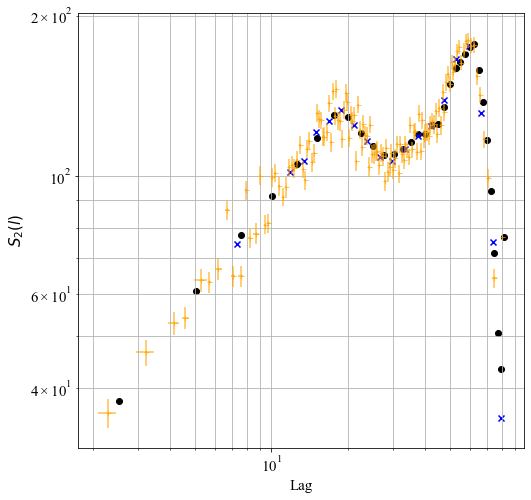

In [32]:
fig, ax=plt.subplots(figsize=(8,8))

plt.scatter(table['lag']['mean'],table['qvd']['mean'], marker="o", color='black',)
#ax.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt="o", color='red', alpha=0.7, markersize=5)

plt.scatter(sfh2.s['mean'],sfh2.dV2['mean'], marker="x", color='blue',)
ax.errorbar(sfh['Lag'],sfh['Nmqvd'],xerr=sfh.ErrX,yerr=sfh.ErrY, fmt="+", color='orange', alpha=0.7, markersize=5)

ax.set(xscale='log',yscale='log')
ax.set(xlabel='Lag', ylabel='$S_{2}(l)$')
plt.grid(True, which="both", ls="-")

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

In [31]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 8.162569761276245 seconds ---
